In [1]:

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import jieba
import re

from itertools import chain, combinations
import json
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random

import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cosine, euclidean

import jax
import jax.numpy as jnp
from jax import grad, jit, random

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

np.random.seed(0)

## data 

In [205]:

ratings_1_neg = pd.read_csv('data/ratings_1_neg.csv')
ratings_1_pos= pd.read_csv('data/ratings_1_pos.csv')
ratings_2_neg = pd.read_csv('data/ratings_2_neg.csv')
ratings_2_pos = pd.read_csv('data/ratings_2_pos.csv')


In [207]:

#ratings_1= ratings.loc[ratings['movieId'].isin([22,23])]
#ratings_1_neg= ratings_1[(ratings_1['like'] >=0) & (ratings_1['rating'] <=3)]


#ratings_1_neg = ratings_1_neg.sample(10000, random_state=1)

text_1_neg= ratings_1_neg['comment'].values
rating_1_neg=ratings_1_neg['rating'].values
print(text_1_neg.shape)


#ratings_1= ratings.loc[ratings['movieId'].isin([22,23])]
#ratings_1_pos= ratings_1[(ratings_1['like'] >=0) & (ratings_1['rating'] >=4)]
#ratings_1_pos = ratings_1_pos.sample(10000, random_state=1)

text_1_pos= ratings_1_pos['comment'].values
rating_1_pos=ratings_1_pos['rating'].values
print(text_1_pos.shape)

#ratings_2= ratings.loc[ratings['movieId'].isin([11])]
#ratings_2_neg= ratings_2[(ratings_2['like'] >=0) & (ratings_2['rating'] <=3)]
#ratings_2_neg = ratings_2_neg.sample(10000, random_state=1)

text_2_neg= ratings_2_neg['comment'].values
rating_2_neg=ratings_2_neg['rating'].values
print(text_2_neg.shape)


#ratings_2= ratings.loc[ratings['movieId'].isin([11])]
#ratings_2_pos= ratings_2[(ratings_2['like'] >=0) & (ratings_2['rating'] >=4)]
#ratings_2_pos = ratings_2_pos.sample(10000, random_state=1)

text_2_pos= ratings_2_pos['comment'].values
rating_2_pos=ratings_2_pos['rating'].values
print(text_2_pos.shape)

(10000,)
(10000,)
(10000,)
(10000,)


In [4]:
text_1= np.concatenate([text_1_neg,text_1_pos])
text_2= np.concatenate([text_2_neg,text_2_pos])

sent_1= np.array([0]*len(text_1_neg)+[1]*len(text_1_pos))
sent_2= np.array([0]*len(text_2_neg)+[1]*len(text_2_pos))

In [5]:
def seg_context_sent(x):
    regex_pattern = r"[，。！？]"
    s = (re.split(regex_pattern,x))
    return s

def seg_cut(string):
    seg_list = list(jieba.cut(string))
    res=[]
    for seg in seg_list:
        if len(re.findall(r'[\u4e00-\u9fff]+',seg) )==0:
            continue
        res.append(seg)
    return res

def tokenize(text):
    tokens=[]
    for comm in text:
        string_lst = seg_context_sent(comm)
        for string in string_lst:
            jieba_res = seg_cut(string)
            jieba_res = list(filter(lambda x: len(x)>1,jieba_res))
            tokens.append(jieba_res)
    return tokens
    
tokens1=tokenize(text_1)
tokens2=tokenize(text_2)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sy/n2t2cdd16kb_hwrkbkw7b0dw0000gn/T/jieba.cache
Loading model cost 0.291 seconds.
Prefix dict has been built successfully.


In [6]:

def whole_tokenize(text):
    tokens=[]
    for comm in text:
        cur=[]
        string_lst = seg_context_sent(comm)
        for string in string_lst:
            jieba_res = seg_cut(string)
            jieba_res = list(filter(lambda x: len(x)>1,jieba_res))
            cur+=(jieba_res)
        tokens.append(cur)
    return tokens
    
whole_tokens1=whole_tokenize(text_1)
whole_tokens2=whole_tokenize(text_2)

In [7]:
def generate_word_context_pairs(tokens_list, window_size=5):
    word_context_pairs = []
    for tokens in tokens_list:
        sequence_length = len(tokens)
        for index, word in enumerate(tokens):
            # Define the start and end index of the context window
            start_index = max(0, index - window_size)
            end_index = min(sequence_length, index + window_size + 1)

            # Generate context words within the window, excluding the target word itself
            context_words = tokens[start_index:index] + tokens[index + 1:end_index]

            # Create word-context pairs for the target word with each of its context words
            for context_word in context_words:
                word_context_pairs.append((word, context_word))

    return word_context_pairs


word_context_pairs1 = generate_word_context_pairs(tokens1)
word_context_pairs2 = generate_word_context_pairs(tokens2)

In [8]:


def select_top_words(word_context_pairs1,  word_context_pairs2,least_freq=200):
    word_frequencies1 = dict(Counter([word for pair in word_context_pairs1 for word in pair]))
    word_frequencies2 = dict(Counter([word for pair in word_context_pairs2 for word in pair]))
    top_words = set([word for word  in word_frequencies1 if word_frequencies1[word] >= least_freq]) & set([word for word in word_frequencies2 if word_frequencies2[word] >= least_freq])
    return top_words

def update_pairs(word_context_pairs, top_words):
    # Filter word_context_pairs to only include pairs where both words are in the top words
    updated_pairs = [(word, context) for word, context in word_context_pairs if word in top_words and context in top_words]
    return updated_pairs

top_words = select_top_words(word_context_pairs1,word_context_pairs2)

print(f"Number of top words: {len(top_words)}")
updated_word_context_pairs1= update_pairs(word_context_pairs1, top_words)
print(f"Number of updated word-context pairs: {len(updated_word_context_pairs1)}")
updated_word_context_pairs2= update_pairs(word_context_pairs2, top_words)
print(f"Number of updated word-context pairs: {len(updated_word_context_pairs2)}")


Number of top words: 829
Number of updated word-context pairs: 339904
Number of updated word-context pairs: 410112


## methods

### glove

Iteration 10: Total Loss = 2623.7911470705653
Iteration 20: Total Loss = 1572.5619633220429
Iteration 30: Total Loss = 1099.7564854310551
Iteration 40: Total Loss = 859.3993278005089
Iteration 50: Total Loss = 731.4889729095788
Iteration 60: Total Loss = 656.2297181860804
Iteration 70: Total Loss = 607.8600499801865
Iteration 80: Total Loss = 574.5780112670025
Iteration 90: Total Loss = 550.3902013176047
Iteration 100: Total Loss = 532.0339375524771


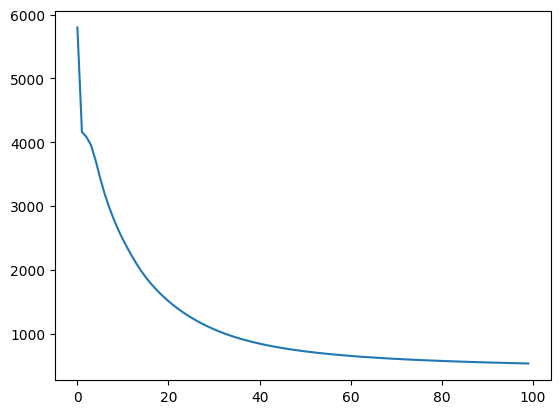

In [9]:



def train_glove_with_weights(updated_word_context_pairs, top_words, vector_size=50, iterations=100, learning_rate=0.05, x_max=100, alpha=0.75):
    filtered_pairs = [(word, context) for word, context in updated_word_context_pairs if word in top_words and context in top_words]
    np.random.seed(0)
    # Rebuild vocab based on filtered pairs
    vocab = set(top_words)
    vocab_size = len(vocab)
    
    # Mapping from words to indices
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    np.random.seed(0)
    # Initialize word vectors and biases
    W = np.random.randn(vocab_size, vector_size) * 0.01
    np.random.seed(1)
    W_prime = np.random.randn(vocab_size, vector_size) * 0.01
    np.random.seed(2)
    b = np.random.randn(vocab_size) * 0.01  # Bias for words
    np.random.seed(3)
    b_prime = np.random.randn(vocab_size) * 0.01  # Bias for context words
    
    # Count co-occurrences within filtered pairs
    co_occurrences = Counter(filtered_pairs)
    
    loss_tracking = []  # To track loss over iterations
    
    for iteration in range(iterations):
        total_loss = 0  # Accumulate loss for this iteration
        for (word, context), co_occurrence in co_occurrences.items():
            word_idx = word_to_idx[word]
            context_idx = word_to_idx[context]
            
            # Weighting function
            weight =  (co_occurrence / x_max) ** alpha if co_occurrence < x_max else 1
            
            # Calculate predictions and errors
            dot_product = np.dot(W[word_idx], W_prime[context_idx]) + b[word_idx] + b_prime[context_idx]
            error = dot_product - np.log(co_occurrence)
            
            # Simplified GloVe loss for this pair (ignoring weighting for simplicity)
            loss = weight * (error ** 2)
            total_loss += loss
            
            # Gradient calculations for vectors and biases
            grad_w = weight * error * W_prime[context_idx]
            grad_w_prime = weight * error * W[word_idx]
            grad_b = weight * error
            grad_b_prime = weight * error
        
            # Update vectors and biases
            W[word_idx] -= learning_rate * grad_w
            W_prime[context_idx] -= learning_rate * grad_w_prime
            b[word_idx] -= learning_rate * grad_b
            b_prime[context_idx] -= learning_rate * grad_b_prime
        if (iteration + 1) % 10 == 0:  # Check if the iteration is divisible by 10
            print(f"Iteration {iteration + 1}: Total Loss = {total_loss}")
        loss_tracking.append(total_loss)
    # Average the word and context vectors for final embeddings
    word_embeddings = {word: (W[word_to_idx[word]] + W_prime[word_to_idx[word]]) / 2 for word in vocab}
    return word_embeddings, loss_tracking
W1_glove,loss1_glove= train_glove_with_weights(updated_word_context_pairs1, top_words, vector_size=50, iterations=100, learning_rate=0.1, x_max=100, alpha=0.75)
plt.plot(loss1_glove)
plt.show()

Iteration 10: Total Loss = 3028.1118918981397
Iteration 20: Total Loss = 1782.254464945246
Iteration 30: Total Loss = 1282.8533789991536
Iteration 40: Total Loss = 1046.027605366543
Iteration 50: Total Loss = 923.6500523421505
Iteration 60: Total Loss = 852.0162127399382
Iteration 70: Total Loss = 805.747446935573
Iteration 80: Total Loss = 773.5822988052538
Iteration 90: Total Loss = 749.9101077586316
Iteration 100: Total Loss = 731.7017387615837


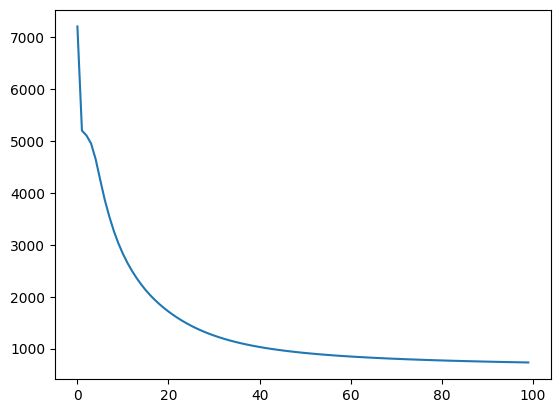

In [10]:
W2_glove,loss2_glove= train_glove_with_weights(updated_word_context_pairs2, top_words,vector_size=50, iterations=100,learning_rate=0.1, x_max=100, alpha=0.75)
plt.plot(loss2_glove)
plt.show()

### sgns

Iteration 1/30, Total Loss: 899312.8352519624
Iteration 2/30, Total Loss: 843876.3047536094
Iteration 3/30, Total Loss: 832984.086001495
Iteration 4/30, Total Loss: 827209.5716394293
Iteration 5/30, Total Loss: 823639.3552096004
Iteration 6/30, Total Loss: 821758.6655993885
Iteration 7/30, Total Loss: 820644.571620394
Iteration 8/30, Total Loss: 819454.6132970265
Iteration 9/30, Total Loss: 819622.0401008404
Iteration 10/30, Total Loss: 819053.8007825157
Iteration 11/30, Total Loss: 819010.6376927935
Iteration 12/30, Total Loss: 818860.6818449732
Iteration 13/30, Total Loss: 818817.7285804051
Iteration 14/30, Total Loss: 818788.3489786582
Iteration 15/30, Total Loss: 818445.1482284729
Iteration 16/30, Total Loss: 818538.8356544733
Iteration 17/30, Total Loss: 818722.0754400814
Iteration 18/30, Total Loss: 818411.3721803887
Iteration 19/30, Total Loss: 818628.008998565
Iteration 20/30, Total Loss: 818796.6087611709
Iteration 21/30, Total Loss: 818663.4543693805
Iteration 22/30, Total Lo

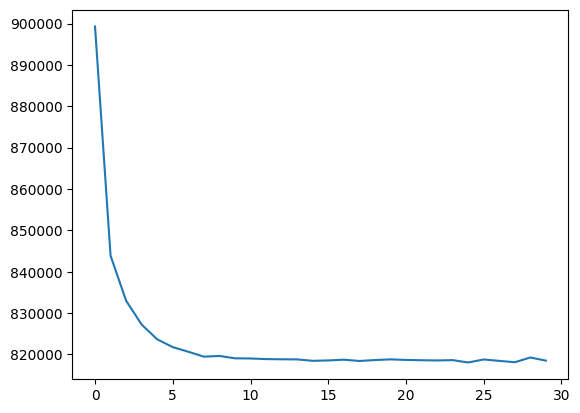

In [11]:
def train_sgns(updated_word_context_pairs, top_words, vector_size=50, iterations=100, learning_rate=0.05, negative_samples=5):
    np.random.seed(1234)

    # Convert top_words into indices and filter word_frequencies
    word_to_idx = {word: i for i, word in enumerate(top_words)}
    vocab_size = len(top_words)
    word_frequencies = Counter([word for pair in updated_word_context_pairs for word in pair])

    adjusted_freqs = np.array([word_frequencies.get(word, 0) for word in top_words]) ** 0.75
    sampling_distribution = adjusted_freqs / adjusted_freqs.sum()
    
    np.random.seed(0)
    W = np.random.rand(vocab_size, vector_size) * 0.01  # Word vector
    np.random.seed(1)
    W_prime = np.random.rand(vocab_size, vector_size) * 0.01  # Context word vectors
    losses = []
    
    for iteration in range(iterations):
        total_loss = 0
        for word, context in updated_word_context_pairs:
            if word not in word_to_idx or context not in word_to_idx:
                continue  # Skip pairs not in top_words

            word_id, context_id = word_to_idx[word], word_to_idx[context]

            # Sample negative words based on frequency
            sampled_negatives = np.random.choice(vocab_size, negative_samples, p=sampling_distribution)
            
            labels = np.array([1] + [0] * negative_samples)
            context_ids = np.array([context_id] + list(sampled_negatives))
            
            u = W[word_id]
            v = W_prime[context_ids]
            
            scores = np.dot(v, u)
            sigmoid_scores = 1 / (1 + np.exp(-scores))
            loss = - np.sum(np.log(sigmoid_scores) * labels + np.log(1 - sigmoid_scores) * (1 - labels))
            total_loss += loss
            
            # Compute gradients
            grad = (sigmoid_scores - labels).reshape(-1, 1) * u
            grad_u = np.sum((sigmoid_scores - labels).reshape(-1, 1) * v, axis=0)
            
            # Update embeddings
            W[word_id] -= learning_rate * grad_u
            for i, context_id in enumerate(context_ids):
                W_prime[context_id] -= learning_rate * grad[i]
                
        losses.append(total_loss)
        #if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}/{iterations}, Total Loss: {total_loss}")
            
    W_sgns={v: W[word_to_idx[v]] for v in top_words}
    return W_sgns, losses

W1_sgns,loss1_sgns= train_sgns(updated_word_context_pairs1, top_words, vector_size=50, iterations=30, learning_rate=0.05, negative_samples=5)
plt.plot(loss1_sgns)

Iteration 1/30, Total Loss: 1066003.8573642557
Iteration 2/30, Total Loss: 1003450.1452741649
Iteration 3/30, Total Loss: 993694.8626728647
Iteration 4/30, Total Loss: 988812.4577687529
Iteration 5/30, Total Loss: 986286.3925867223
Iteration 6/30, Total Loss: 984597.4289178217
Iteration 7/30, Total Loss: 983909.2156050449
Iteration 8/30, Total Loss: 983196.3262653676
Iteration 9/30, Total Loss: 982958.5852347539
Iteration 10/30, Total Loss: 982857.0581495464
Iteration 11/30, Total Loss: 982239.632036334
Iteration 12/30, Total Loss: 982627.683690366
Iteration 13/30, Total Loss: 982311.2539165522
Iteration 14/30, Total Loss: 982775.3927444234
Iteration 15/30, Total Loss: 981997.8651037639
Iteration 16/30, Total Loss: 982600.3357031541
Iteration 17/30, Total Loss: 982260.1135797402
Iteration 18/30, Total Loss: 982452.7592787783
Iteration 19/30, Total Loss: 982316.980973385
Iteration 20/30, Total Loss: 982098.4600999738
Iteration 21/30, Total Loss: 982870.5892605531
Iteration 22/30, Total 

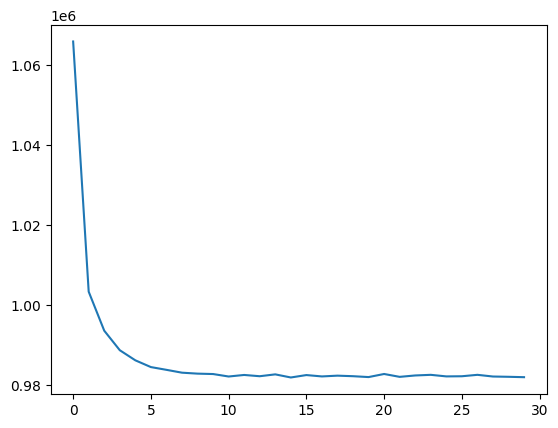

In [12]:
W2_sgns,loss2_sgns= train_sgns(updated_word_context_pairs2, top_words, vector_size=50, iterations=30, learning_rate=0.05, negative_samples=5)
plt.plot(loss2_sgns)

### svd ppmi

In [13]:

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from collections import Counter
import math

def build_shifted_pmi_matrix(updated_word_context_pairs, top_words, negative_samples):
    word_to_idx = {word: i for i, word in enumerate(top_words)}
    idx_to_word= {i: word for i, word in enumerate(top_words)}
    vocab_size = len(top_words)

    # Initialize counters
    word_context_count = Counter(updated_word_context_pairs)
    word_count = Counter([pair[0] for pair in updated_word_context_pairs])
    context_count = Counter([pair[1] for pair in updated_word_context_pairs])
    total_count = sum(word_context_count.values())

    # Initialize sparse matrix
    row = []
    col = []
    data = []
    
    # Ensure positive arguments for logarithm
    for (word, context), w_c_count in word_context_count.items():
        if word in word_to_idx and context in word_to_idx:
            row_idx = word_to_idx[word]
            col_idx = word_to_idx[context]
            joint_prob = w_c_count / total_count
            word_prob = word_count[word] / total_count
            context_prob = context_count[context] / total_count

            # Calculate PMI, ensuring positive arguments for log
            if joint_prob > 0 and word_prob > 0 and context_prob > 0:
                pmi = math.log(joint_prob / (word_prob * context_prob), 2)
                shifted_pmi = max(pmi - math.log(negative_samples, 2), 0)  # Apply shifting and ensure non-negativity
            else:
                shifted_pmi = 0

            row.append(row_idx)
            col.append(col_idx)
            data.append(shifted_pmi)

    pmi_matrix = csr_matrix((data, (row, col)), shape=(vocab_size, vocab_size))
    return idx_to_word, pmi_matrix

def train_embeddings_svd(updated_word_context_pairs, top_words, vector_size, negative_samples, gamma=1/2):
    # Build shifted PMI matrix
    idx_to_word,shifted_pmi_matrix = build_shifted_pmi_matrix(updated_word_context_pairs, top_words, negative_samples)

    # Perform SVD
    u, s, vt = svds(shifted_pmi_matrix, k=vector_size)

    # Compute word embeddings
   
        
    embeddings = u   @ np.diag((s)**(gamma))
    word2embedding = {idx_to_word[i]: embeddings[i] for i in range(embeddings.shape[0])}
    
    return word2embedding

W1_svd_k1_g0 = train_embeddings_svd(updated_word_context_pairs1, top_words, vector_size=50, negative_samples=1,gamma=0)
W2_svd_k1_g0 = train_embeddings_svd(updated_word_context_pairs2, top_words, vector_size=50, negative_samples=1,gamma=0)


W1_svd_k5_g0 = train_embeddings_svd(updated_word_context_pairs1, top_words, vector_size=50, negative_samples=5,gamma=0)
W2_svd_k5_g0 = train_embeddings_svd(updated_word_context_pairs2, top_words, vector_size=50, negative_samples=5,gamma=0)

### ppmi

In [14]:

def train_embeddings_ppmi(updated_word_context_pairs, top_words, negative_samples):
    word_to_idx = {word: i for i, word in enumerate(top_words)}
    idx_to_word= {i: word for i, word in enumerate(top_words)}
    vocab_size = len(top_words)

    # Initialize counters
    word_context_count = Counter(updated_word_context_pairs)
    word_count = Counter([pair[0] for pair in updated_word_context_pairs])
    context_count = Counter([pair[1] for pair in updated_word_context_pairs])
    total_count = sum(word_context_count.values())

    # Initialize sparse matrix
    row = []
    col = []
    data = []
    
    # Ensure positive arguments for logarithm
    for (word, context), w_c_count in word_context_count.items():
        if word in word_to_idx and context in word_to_idx:
            row_idx = word_to_idx[word]
            col_idx = word_to_idx[context]
            joint_prob = w_c_count / total_count
            word_prob = word_count[word] / total_count
            context_prob = context_count[context] / total_count

            # Calculate PMI, ensuring positive arguments for log
            if joint_prob > 0 and word_prob > 0 and context_prob > 0:
                pmi = math.log(joint_prob / (word_prob * context_prob), 2)
                shifted_pmi = max(pmi - math.log(negative_samples, 2), 0)  # Apply shifting and ensure non-negativity
            else:
                shifted_pmi = 0

            row.append(row_idx)
            col.append(col_idx)
            data.append(shifted_pmi)

    pmi_matrix = csr_matrix((data, (row, col)), shape=(vocab_size, vocab_size)).toarray()
    word2embedding = {idx_to_word[i]: pmi_matrix[i] for i in range(pmi_matrix.shape[0])}
    return word2embedding

W1_ppmi_k1 = train_embeddings_ppmi(updated_word_context_pairs1, top_words, negative_samples=1)
W2_ppmi_k1  = train_embeddings_ppmi(updated_word_context_pairs2, top_words, negative_samples=1)

W1_ppmi_k5 = train_embeddings_ppmi(updated_word_context_pairs1, top_words, negative_samples=5)
W2_ppmi_k5  = train_embeddings_ppmi(updated_word_context_pairs2, top_words, negative_samples=5)



### text2vec

In [15]:
from text2vec import SentenceModel
text2vecmodel= SentenceModel()

/Users/baojiaqi/Downloads/notebooks_export/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-09 15:13:50.512 | DEBUG    | text2vec.sentence_model:__init__:80 - Use device: cpu


In [16]:
W_text2vec = {w:text2vecmodel.encode(w) for w in top_words}

## Evaluations

In [17]:

embeddings = {
    'Glove W1': W1_glove,
    'SGNS W1': W1_sgns,
    
    'SVD W1 k1 g0': W1_svd_k1_g0,
    'SVD W1 k5 g0': W1_svd_k5_g0,
   

    'PPMI W1 k1': W1_ppmi_k1,
    'PPMI W1 k5': W1_ppmi_k5,

    'Onehot W1': {word: np.eye(len(top_words))[i] for i, word in enumerate(top_words)},  # W1_onehot
    'text2vec W1': W_text2vec,
    
    'Glove W2': W2_glove,
    'SGNS W2': W2_sgns,
    'SVD W2 k1 g0': W2_svd_k1_g0,
    'SVD W2 k5 g0': W2_svd_k5_g0,
   
    
    'PPMI W2 k1': W2_ppmi_k1,
    'PPMI W2 k5': W2_ppmi_k5,
 
    'Onehot W2': {word: np.eye(len(top_words))[i] for i, word in enumerate(top_words)},   # W2_onehot
    'text2vec W2': W_text2vec,
}

classifiers = {
    #'SVM': svm.SVC(kernel='linear',max) ,
    'LogisticRegression': LogisticRegression(max_iter=1000, penalty=None),
    #'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(weights='distance', n_neighbors=10),
    
    
}

# Data and labels for each token set
data_sets = {
    'Token Set 1': (whole_tokens1, sent_1),
    'Token Set 2': (whole_tokens2, sent_2)
}

In [18]:
def docs_to_frequency_matrix(docs, top_words):
    frequency_matrix = np.zeros((len(docs), len(top_words)), dtype=int)
    
    # Create a mapping from top words to their indices for easy access
    word_to_index = {word: i for i, word in enumerate(top_words)}
    
    # Iterate over each document
    for doc_idx, doc in enumerate(docs):
        # Count the frequency of each word in the document
        word_count = {}
        for word in doc:
            if word in top_words:
                if word not in word_count:
                    word_count[word] = 0
                word_count[word] += 1
                
        # Update the frequency matrix
        for word, count in word_count.items():
            word_idx = word_to_index[word]
            frequency_matrix[doc_idx, word_idx] = count
            
    return frequency_matrix


### words similarity

In [19]:
def compute_similarity_matrix(embeddings,l2norm=True):
    words = list(embeddings.keys())
    similarity_matrix = {}
    for i, word1 in enumerate(words):
        for word2 in words[i+1:]:  # Avoid repeating comparisons
            if l2norm:
                # let's normalize embeddings[word1] into unit vector
                normalized_word1 = embeddings[word1] / np.linalg.norm(embeddings[word1])
                normalized_word2 = embeddings[word2] / np.linalg.norm(embeddings[word2])
                similarity = -np.linalg.norm(normalized_word1  - normalized_word2)
            else:
                similarity = np.dot(embeddings[word1], embeddings[word2]) / (np.linalg.norm(embeddings[word1]) * np.linalg.norm(embeddings[word2]))
            similarity_matrix[(word1, word2)] = similarity
    return similarity_matrix

from scipy.stats import pearsonr
def similarity_list_correlation(similarity_list1, similarity_list2):
    common_pairs = set(similarity_list1.keys()) & set(similarity_list2.keys())
    if not common_pairs:
        return None 
    
    similarities1 = [similarity_list1[pair] for pair in common_pairs]
    similarities2 = [similarity_list2[pair] for pair in common_pairs]
    
    correlation, _ = pearsonr(similarities1, similarities2)

    return correlation

def compute_pearson(similarity_matrix_truth, embeddings2,l2norm=True):
   
    similarity_matrix2 = compute_similarity_matrix(embeddings2,l2norm)
    return similarity_list_correlation(similarity_matrix_truth, similarity_matrix2)



In [179]:
similarity_matrix_text2vec= compute_similarity_matrix(W_text2vec,l2norm=False)
for embedding_name, embedding in embeddings.items():
    if 'onehot' not in embedding_name.lower():
        similarity = compute_pearson(similarity_matrix_text2vec, embedding, l2norm=False)
        print(f"{embedding_name} with Similarity:  {similarity}")

Glove W1 with Similarity:  -0.01972587662964297
SGNS W1 with Similarity:  0.06910842364744176
SVD W1 k1 g0 with Similarity:  0.04798086244324742
SVD W1 k5 g0 with Similarity:  0.045189936520165626
PPMI W1 k1 with Similarity:  0.15460008090252397
PPMI W1 k5 with Similarity:  0.03057489304113152
text2vec W1 with Similarity:  1.0
Glove W2 with Similarity:  -0.009304099811309922
SGNS W2 with Similarity:  0.08282353162773562
SVD W2 k1 g0 with Similarity:  0.04894317236901321
SVD W2 k5 g0 with Similarity:  0.04547853696527063
PPMI W2 k1 with Similarity:  0.1426308781230821
PPMI W2 k5 with Similarity:  0.026336332671208915
text2vec W2 with Similarity:  1.0


### sentiment classification

#### lda

In [22]:
import lda

def preprocess_docs_topic_model(docs, sentiments, top_words, classifier, test_size=0.2, random_state=42, least_words=1):
    filtered_sentiments=[]
    filtered_docs=[]
    for i, doc in enumerate(docs):
        if len([word for word in doc if word in top_words]) >= least_words:
            filtered_docs.append(doc)
            filtered_sentiments.append(sentiments[i])  
    print(f" number of pos comments {len([senti for senti in filtered_sentiments if senti==1])}")
    print(f" number of neg comments {len([senti for senti in filtered_sentiments if senti==0])}")
    print(f"average length of filtered docs {np.mean([len(doc) for doc in filtered_docs])}")
    model = lda.LDA(n_topics=50, n_iter=200, random_state=1)
    
    frequency_matrix = docs_to_frequency_matrix(filtered_docs, top_words)

    model.fit(frequency_matrix.astype(int))
    doc2pi_topics =model.doc_topic_
    
            
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(doc2pi_topics,filtered_sentiments, test_size=test_size, random_state=random_state)
    
    # Train the classifier
    classifier.fit(X_train, y_train)
 
    #y_pred = classifier.predict_proba(X_test)
    
    y_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    #log_loss_score = log_loss(y_test, y_pred)
    return test_accuracy

In [23]:

# Iterate over classifiers
for classifier_name, classifier in classifiers.items():
    print(f"\nUsing Classifier: {classifier_name}")
   
    test_accuracy = preprocess_docs_topic_model(whole_tokens1, sent_1,top_words, classifier)
    
    print(f"Data set 1 with  Acc:  {test_accuracy}")
    
    test_accuracy = preprocess_docs_topic_model(whole_tokens2, sent_2, top_words,classifier)
    
    print(f"Data set 2 with  Acc:  {test_accuracy}")

INFO:lda:n_documents: 17768
INFO:lda:vocab_size: 829
INFO:lda:n_words: 132554
INFO:lda:n_topics: 50
INFO:lda:n_iter: 200



Using Classifier: LogisticRegression
 number of pos comments 9128
 number of neg comments 8640
average length of filtered docs 12.491670418730301


INFO:lda:<0> log likelihood: -1503254
INFO:lda:<10> log likelihood: -1064366
INFO:lda:<20> log likelihood: -1002593
INFO:lda:<30> log likelihood: -975265
INFO:lda:<40> log likelihood: -961665
INFO:lda:<50> log likelihood: -952421
INFO:lda:<60> log likelihood: -945696
INFO:lda:<70> log likelihood: -939937
INFO:lda:<80> log likelihood: -936385
INFO:lda:<90> log likelihood: -934426
INFO:lda:<100> log likelihood: -932828
INFO:lda:<110> log likelihood: -930204
INFO:lda:<120> log likelihood: -928719
INFO:lda:<130> log likelihood: -927510
INFO:lda:<140> log likelihood: -926788
INFO:lda:<150> log likelihood: -925151
INFO:lda:<160> log likelihood: -925524
INFO:lda:<170> log likelihood: -924453
INFO:lda:<180> log likelihood: -924028
INFO:lda:<190> log likelihood: -923136
INFO:lda:<199> log likelihood: -922970
INFO:lda:n_documents: 18168
INFO:lda:vocab_size: 829
INFO:lda:n_words: 160606
INFO:lda:n_topics: 50
INFO:lda:n_iter: 200


Data set 1 with  Acc:  0.6536297129994373
 number of pos comments 8913
 number of neg comments 9255
average length of filtered docs 14.87373403786878


INFO:lda:<0> log likelihood: -1818714
INFO:lda:<10> log likelihood: -1297640
INFO:lda:<20> log likelihood: -1215558
INFO:lda:<30> log likelihood: -1182587
INFO:lda:<40> log likelihood: -1168239
INFO:lda:<50> log likelihood: -1157817
INFO:lda:<60> log likelihood: -1150175
INFO:lda:<70> log likelihood: -1147314
INFO:lda:<80> log likelihood: -1143100
INFO:lda:<90> log likelihood: -1138359
INFO:lda:<100> log likelihood: -1135886
INFO:lda:<110> log likelihood: -1134004
INFO:lda:<120> log likelihood: -1131371
INFO:lda:<130> log likelihood: -1130777
INFO:lda:<140> log likelihood: -1130703
INFO:lda:<150> log likelihood: -1128561
INFO:lda:<160> log likelihood: -1127427
INFO:lda:<170> log likelihood: -1128049
INFO:lda:<180> log likelihood: -1127526
INFO:lda:<190> log likelihood: -1126955
INFO:lda:<199> log likelihood: -1125332
INFO:lda:n_documents: 17768
INFO:lda:vocab_size: 829
INFO:lda:n_words: 132554
INFO:lda:n_topics: 50
INFO:lda:n_iter: 200


Data set 2 with  Acc:  0.6719867914144194

Using Classifier: KNeighbors
 number of pos comments 9128
 number of neg comments 8640
average length of filtered docs 12.491670418730301


INFO:lda:<0> log likelihood: -1503254
INFO:lda:<10> log likelihood: -1064366
INFO:lda:<20> log likelihood: -1002593
INFO:lda:<30> log likelihood: -975265
INFO:lda:<40> log likelihood: -961665
INFO:lda:<50> log likelihood: -952421
INFO:lda:<60> log likelihood: -945696
INFO:lda:<70> log likelihood: -939937
INFO:lda:<80> log likelihood: -936385
INFO:lda:<90> log likelihood: -934426
INFO:lda:<100> log likelihood: -932828
INFO:lda:<110> log likelihood: -930204
INFO:lda:<120> log likelihood: -928719
INFO:lda:<130> log likelihood: -927510
INFO:lda:<140> log likelihood: -926788
INFO:lda:<150> log likelihood: -925151
INFO:lda:<160> log likelihood: -925524
INFO:lda:<170> log likelihood: -924453
INFO:lda:<180> log likelihood: -924028
INFO:lda:<190> log likelihood: -923136
INFO:lda:<199> log likelihood: -922970
INFO:lda:n_documents: 18168
INFO:lda:vocab_size: 829
INFO:lda:n_words: 160606
INFO:lda:n_topics: 50
INFO:lda:n_iter: 200


Data set 1 with  Acc:  0.6041080472706809
 number of pos comments 8913
 number of neg comments 9255
average length of filtered docs 14.87373403786878


INFO:lda:<0> log likelihood: -1818714
INFO:lda:<10> log likelihood: -1297640
INFO:lda:<20> log likelihood: -1215558
INFO:lda:<30> log likelihood: -1182587
INFO:lda:<40> log likelihood: -1168239
INFO:lda:<50> log likelihood: -1157817
INFO:lda:<60> log likelihood: -1150175
INFO:lda:<70> log likelihood: -1147314
INFO:lda:<80> log likelihood: -1143100
INFO:lda:<90> log likelihood: -1138359
INFO:lda:<100> log likelihood: -1135886
INFO:lda:<110> log likelihood: -1134004
INFO:lda:<120> log likelihood: -1131371
INFO:lda:<130> log likelihood: -1130777
INFO:lda:<140> log likelihood: -1130703
INFO:lda:<150> log likelihood: -1128561
INFO:lda:<160> log likelihood: -1127427
INFO:lda:<170> log likelihood: -1128049
INFO:lda:<180> log likelihood: -1127526
INFO:lda:<190> log likelihood: -1126955
INFO:lda:<199> log likelihood: -1125332


Data set 2 with  Acc:  0.6219042377545404


In [24]:

from sklearn.metrics import log_loss
def preprocess_docs(docs, word_embeddings, sentiments,top_words, classifier, test_size=0.2, random_state=42, least_words=1):
    doc_embeddings = []
    filtered_sentiments = []  # To keep track of sentiments for docs with more than lease_words words
     
    for i, doc in enumerate(docs):
        
        if len([word for word in doc if word in top_words]) >= least_words:
            embeddings = np.array([word_embeddings[word] for word in doc if word in word_embeddings])
           
            avg_embedding = embeddings.mean(axis=0)
          
            doc_embeddings.append(avg_embedding)
            filtered_sentiments.append(sentiments[i])  
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(doc_embeddings, filtered_sentiments, test_size=test_size, random_state=random_state)
    

    classifier.fit(X_train, y_train)
 
    #y_pred = classifier.predict_proba(X_test)
    
    y_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    #log_loss_score = log_loss(y_test, y_pred)
    return test_accuracy


In [25]:

# Iterate over classifiers
for classifier_name, classifier in classifiers.items():
    print(f"\nUsing Classifier: {classifier_name}")
    # Iterate over embeddings
    for embedding_name, embedding in embeddings.items():
        # Iterate over data sets
        for data_set_name, (tokens, sentiments) in data_sets.items():
            if 'W1' in embedding_name:
                if '2' in data_set_name:
                    continue
            if 'W2' in embedding_name:
                if '1' in data_set_name:
                    continue
            test_accuracy = preprocess_docs(tokens, embedding,sentiments, top_words, classifier)
            print(f"{embedding_name} with {data_set_name} Acc:  {test_accuracy}")



Using Classifier: LogisticRegression
Glove W1 with Token Set 1 Acc:  0.6848621271806415
SGNS W1 with Token Set 1 Acc:  0.6775464265616207
SVD W1 k1 g0 with Token Set 1 Acc:  0.6913337084974677
SVD W1 k5 g0 with Token Set 1 Acc:  0.6637591446257738
PPMI W1 k1 with Token Set 1 Acc:  0.7326955543050084
PPMI W1 k5 with Token Set 1 Acc:  0.729037703995498
Onehot W1 with Token Set 1 Acc:  0.7304445694991559


/Users/baojiaqi/Downloads/notebooks_export/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


text2vec W1 with Token Set 1 Acc:  0.7341024198086663
Glove W2 with Token Set 2 Acc:  0.7003302146395157
SGNS W2 with Token Set 2 Acc:  0.6970280682443588
SVD W2 k1 g0 with Token Set 2 Acc:  0.7025316455696202
SVD W2 k5 g0 with Token Set 2 Acc:  0.682443588332416
PPMI W2 k1 with Token Set 2 Acc:  0.7179416620803523
PPMI W2 k5 with Token Set 2 Acc:  0.7176664832140892
Onehot W2 with Token Set 2 Acc:  0.71326362135388


/Users/baojiaqi/Downloads/notebooks_export/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


text2vec W2 with Token Set 2 Acc:  0.7220693450742983

Using Classifier: KNeighbors
Glove W1 with Token Set 1 Acc:  0.6789532920652785
SGNS W1 with Token Set 1 Acc:  0.6631963984243107
SVD W1 k1 g0 with Token Set 1 Acc:  0.6857062464828363
SVD W1 k5 g0 with Token Set 1 Acc:  0.6699493528418683
PPMI W1 k1 with Token Set 1 Acc:  0.6845807540799099
PPMI W1 k5 with Token Set 1 Acc:  0.6713562183455262
Onehot W1 with Token Set 1 Acc:  0.6637591446257738
text2vec W1 with Token Set 1 Acc:  0.6769836803601575
Glove W2 with Token Set 2 Acc:  0.6788662630709962
SGNS W2 with Token Set 2 Acc:  0.6730875068794716
SVD W2 k1 g0 with Token Set 2 Acc:  0.6788662630709962
SVD W2 k5 g0 with Token Set 2 Acc:  0.6469455145844799
PPMI W2 k1 with Token Set 2 Acc:  0.6730875068794716
PPMI W2 k5 with Token Set 2 Acc:  0.6505228398458999
Onehot W2 with Token Set 2 Acc:  0.6576774903687397
text2vec W2 with Token Set 2 Acc:  0.6706108970831041


## embedding bias

#### here is the complete list of target words and attribute words we selected

In [143]:
acting_related_words2trans={
    '表演':'acting', 
    '演技':'acting',
    '主演':'leading actor',
    #'演绎':'interpretation',
    '演出':'performance',
    '演绎':'interpretation',
    '演员':'actor',
}
writing_related_words2trans={
    '剧本':'script',
    '剧情':'plot',
    '情节':'plot',
    '编剧':'screenwriter',
    '节奏':'pace',
    '套路':'formula',
    '故事':'story',
    '故事情节':'storyline',
    #'衔接':'transition',
    '衔接':'transition',
    '台词':'lines',  
}

look_related_words2trans={
'衣服':'clothes',
'服装':'costume',
'颜值':'look'}  #'姑娘':'girl','少女':'girl' } #'姑娘':'girl','少女':'girl'}


director_related_words2trans={ 
 '拍摄':'shooting',
'摄影':'cinematography',
'镜头':'shot',
 '导演':'director',
 '剪辑':'editing', 
 '长镜头': 'long shot', #长镜头
 '水准':'level', #水准
 '功力':'skill',} #功力

life_related_words2trans={
            '青春':'youth',
            '爱情':'love',
            '成长':'growth',
            
            '现实':'reality',
            #'结局':'ending',
            '结局':'ending',
            '成长':'grow',
            '人生':'life',
           
            '梦想':'dream',
            '选择':'choice',
            #'珍惜':'cherish',
            '珍惜':'cherish',
            '触动':'touching',
            #'温暖':'warm',
            '温暖':'warm',
           '眼泪':'tears'}
           
pos_words2trans={
    '四星':'four stars',
    '五星':'five stars',
    '好评':'good review',
    '不错':'good',
    '值得':'worth',
    '推荐':'recommend',
    '喜欢':'like',
    '满意':'satisfied',
    '满分':'full marks',
    '加一星':'add one star',
    '五分':'five points',
    '厉害':'awesome',
}

neg_words2trans={
    '一星':'one star',
    '一分':'one point',
    '不行':'bad',
    '不好':'bad',
    '低分':'low score',
    '糟糕':'terrible',
    '难看':'ugly',
    '还行':'so-so',
    '普通':'ordinary',
    '缺乏':'lack of',
    '毫无':'nothing',
}


attributes = {
    'negative': neg_words2trans,
    'positive': pos_words2trans,
}

targets ={
    'acting': acting_related_words2trans,
    'writing': writing_related_words2trans,
    'directing': director_related_words2trans,
    'appearance':look_related_words2trans,
    'life':life_related_words2trans,
}


target2color={'acting': '#1f77b4','writing': '#ff7f0e','directing': '#2ca02c','appearance': '#d62728','life': '#9467bd'}
target2loc= {'acting':-0.1, 'writing':-0.05, 'directing':0, 'appearance':0.05, 'life':0.1}
    
#let merges look_related_words2trans, director_related_words2trans, writing_related_words2trans,acting_related_words2trans in one dictionary
all_target_words2trans = {**acting_related_words2trans, **writing_related_words2trans,**director_related_words2trans, **look_related_words2trans,**life_related_words2trans}

### gender projection

#### here is the 5 gender pair words

In [154]:
gender_pairs=[['男人', '女人'], ['男生','女生'], ['男生','姑娘'], ['男生','少女' ], ['男生','妹子']  ]
# let's write a english translation for the above chinese words
english_translations =[['male','female'], ['boy','girl'],['boy','girl'], ['boy','girl'],['boy','girl'] ]

In [166]:
def draw_2_dimen(W1,title,return_var=False):
    gender_directions=[]
    for gender_pair in gender_pairs:
        gender_direction= W1[gender_pair[0]]-W1[gender_pair[1]]
        gender_directions.append(gender_direction)
 

    gender_directions = np.array(gender_directions).T
  
    pca = PCA(n_components=5,random_state=0)
    #do PCA on gender_directions
    vectors_reduced = pca.fit_transform(gender_directions)
    pc1= vectors_reduced[:,0]
    print(1-cosine(W1['男生'],pc1) )
    if (1-cosine(W1['男生'],pc1) )<0:
        pc1=-pc1
    var_explained = pca.explained_variance_ratio_
    
    if return_var:
        return var_explained[0]
    
    print(var_explained)

    
    gender_direction_W1 = pc1

    
    targe2point = {}
        
    for target, target_words2trans in targets.items():
        targe2point[target]={}
        for word, translation in target_words2trans.items():
            word_embedding = W1[word]
            random_projection = target2loc[target]
            gender_projection = 1-cosine(gender_direction_W1, word_embedding)
            targe2point[target][word]= [random_projection , gender_projection]
    
    
    plt.figure(figsize=(6, 6))
    for target, target_words2point in targe2point.items():
            plt.scatter([target_words2point[word][0] for word in target_words2point ],
                        [target_words2point[word][1] for word in target_words2point ]
                        , c= target2color[target], label=target)
           
            for word in target_words2point:
                plt.text(target_words2point[word][0]+0.005, target_words2point[word][1]+0.001,targets[target][word], size=5)
            
            
 
    min_p = min([point[0] for target_words2point in targe2point.values() for point in target_words2point.values()])
    max_p= max([point[0] for target_words2point in targe2point.values() for point in target_words2point.values()])
    limit_x = max(abs(min_p),abs(max_p))
    
    min_p = min([point[1] for target_words2point in targe2point.values() for point in target_words2point.values()])
    max_p= max([point[1] for target_words2point in targe2point.values() for point in target_words2point.values()])
    limit_y = max(abs(min_p),abs(max_p))

    plt.ylim(-limit_y-0.02,limit_y+0.02)
    plt.xlim(-limit_x-0.02,limit_x+0.02)

    plt.xlabel("target class") 
    plt.ylabel("female                   gender projection                        male")

    plt.grid(True)
    # change it to dash line
    plt.axhline(0, color='red', linestyle='--')
    #plt.axvline(0, color='red')
    plt.legend(fontsize=5,loc='lower left')
    plt.title(title)
    plt.savefig(title+'.jpg',  bbox_inches='tight', dpi=200)
    plt.show()
    
   
        

In [160]:
embedding2var_explained={}
for embedding_name, embedding in embeddings.items():
    var_explained = draw_2_dimen(embedding,embedding_name,return_var=True)
    embedding2var_explained[embedding_name]=var_explained
embedding2var_explained

-0.8004384944778999
-0.8187950171398108
-0.7176980829253785
-0.7484166061991888
0.8104871095178824
0.8637895603602883
0.8944271909999159
0.5620629960742622
0.8425989212605485
-0.7935069136077977
-0.7525977201683665
-0.46856863320251074
0.8057641326695787
0.7968309401919849
0.8944271909999159
0.5620629960742622


{'Glove W1': 0.4101864185431029,
 'SGNS W1': 0.6628259137624947,
 'SVD W1 k1 g0': 0.5189191477304333,
 'SVD W1 k5 g0': 0.6022481043408157,
 'PPMI W1 k1': 0.4995393427662842,
 'PPMI W1 k5': 0.5997305330865708,
 'Onehot W1': 0.49999999999999994,
 'text2vec W1': 0.7227834,
 'Glove W2': 0.6678244884538365,
 'SGNS W2': 0.6168630451005258,
 'SVD W2 k1 g0': 0.5168457363070729,
 'SVD W2 k5 g0': 0.5455129008262566,
 'PPMI W2 k1': 0.4854257313539837,
 'PPMI W2 k5': 0.5070937525738272,
 'Onehot W2': 0.49999999999999994,
 'text2vec W2': 0.7227834}

In [165]:
embedding_method='Glove'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name ]))

embedding_method='SGNS'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name ]))

embedding_method='SVD'
embedding_method1='k1'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name and embedding_method1 in embedding_name]))


embedding_method='SVD'
embedding_method1='k5'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name and embedding_method1 in embedding_name]))


embedding_method='PPMI'
embedding_method1='k1'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name and embedding_method1 in embedding_name]))


embedding_method='PPMI'
embedding_method1='k5'
print(np.mean([embedding2var_explained[embedding_name] for embedding_name in embedding2var_explained if embedding_method in embedding_name and embedding_method1 in embedding_name]))

0.5390054534984696
0.6398444794315102
0.5178824420187531
0.5738805025835361
0.49248253706013395
0.553412142830199


-0.8187950171398108
[0.66282591 0.13253837 0.09635442 0.06489934 0.04338197]


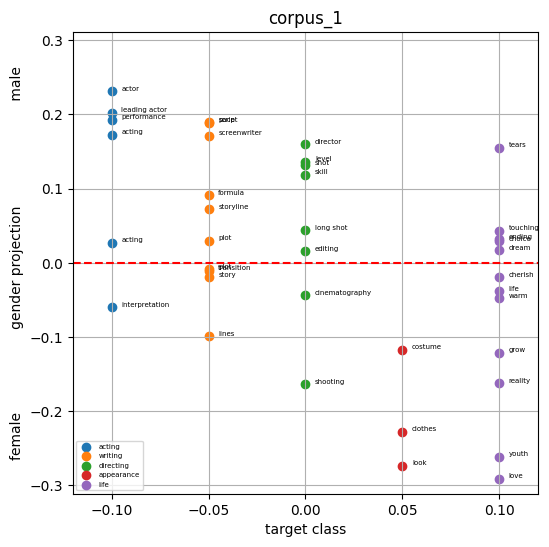

In [168]:
draw_2_dimen(W1_sgns,title='corpus_1')

-0.7935069136077977
[0.61686305 0.1182055  0.11402836 0.09109241 0.05981069]


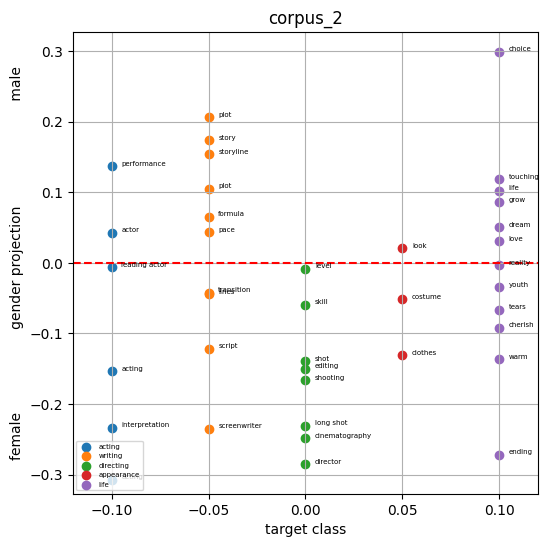

In [169]:
draw_2_dimen(W2_sgns,title='corpus_2')

0.5620629960742622
[0.7227834  0.1125209  0.09297527 0.0545007  0.01721961]


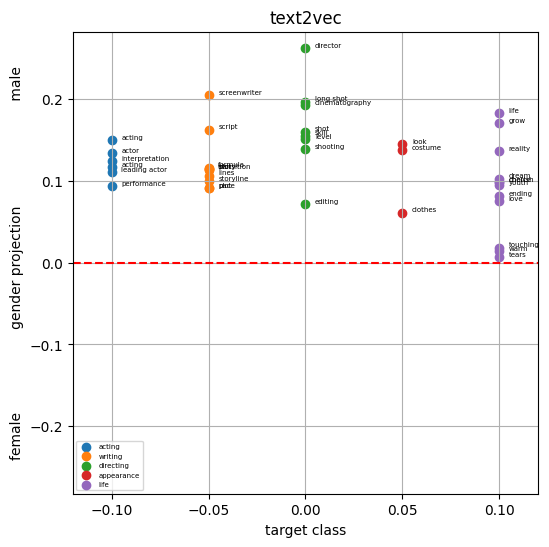

In [170]:
draw_2_dimen(W_text2vec,title='text2vec')

### aspect based sentiment comparision by WEAT test

In [33]:
def average_embedding(embeddings, words):
    valid_embeddings = []
    for word in words:
        if word in embeddings:
            valid_embeddings.append(embeddings[word])
    embedding_array = np.array(valid_embeddings)
    averaged_embedding = np.mean(embedding_array, axis=0)
    
    return averaged_embedding

def average_distance(set1, set2, embeddings, distance_type='euclidean'):
    distances = []
    for word1 in set1:
        for word2 in set2:
            if word1 in embeddings and word2 in embeddings:
                if distance_type == 'euclidean':
                    normalized_word1 = embeddings[word1] / np.linalg.norm(embeddings[word1])
                    normalized_word2 = embeddings[word2] / np.linalg.norm(embeddings[word2])
                    dist = euclidean(normalized_word1,normalized_word2)
                elif distance_type == 'cosine':
                    dist = 1-cosine(embeddings[word1], embeddings[word2])
                distances.append(dist)
    return np.mean(distances)


In [34]:
for targ in targets:
    for attr in attributes:
        dist = average_distance(targets[targ], attributes[attr], W2_glove, distance_type='cosine')
        print(f"Average cosine distance between {targ} and {attr} words: {dist}")

Average cosine distance between acting and negative words: 0.035817648703812995
Average cosine distance between acting and positive words: 0.11767443611193622
Average cosine distance between writing and negative words: 0.05088096447059686
Average cosine distance between writing and positive words: 0.05873290989991676
Average cosine distance between directing and negative words: 0.07279005859564806
Average cosine distance between directing and positive words: 0.10642669149401121
Average cosine distance between look and negative words: 0.055127265893572655
Average cosine distance between look and positive words: 0.1265034403673057
Average cosine distance between life and negative words: -0.11481713687223001
Average cosine distance between life and positive words: -0.09289515058321422


In [120]:
def word_embedding_association_test(related_words2trans, embedding,neg_words2trans,pos_words2trans):
    pos_words = list(pos_words2trans.keys())
    neg_words = list(neg_words2trans.keys())
    related_words = list(related_words2trans.keys())
    word_lst=[]
    for word in related_words:
        pos_lst =[]
        for pos in  pos_words:
           
            dist =1- cosine(embedding[word], embedding[pos])
            pos_lst.append(dist)
        pos_avg  = np.array(pos_lst).mean()
        
        neg_lst =[]
        for neg in  neg_words:
            
            
            dist = 1-cosine(embedding[word], embedding[neg])
            neg_lst.append(dist)
        neg_avg  = np.array(neg_lst).mean()
        
        word_lst.append(pos_avg-neg_avg) 
          
    return (word_lst)
        
def weat_stats(word_lst1,word_lst2):
    mean_diff = sum(word_lst1)/len(word_lst1) - sum(word_lst2)/len(word_lst2)
    std  = np.std(word_lst1 +  word_lst2)
    return mean_diff, mean_diff/std


def word_embedding_association_test_pval(related_words2trans,embedding1,embedding2 ,neg_words2trans,pos_words2trans,test_stats,seed=9):
    
    #for p in range(permutations):
        # let's generate binary random variable of lenth words
    words = list(related_words2trans.keys())
    np.random.seed(seed)
    binary = np.random.choice([0,1],len(words))
   
    words1= [words[i] for i,x  in enumerate(binary) if x==1]
    #words2= [word for i, word  in enumerate(binary) if binary[i]==0]
    pos_words = list(pos_words2trans.keys())
    neg_words = list(neg_words2trans.keys())
    
    word_lst1=[]
    word_lst2=[]
    for word in words:
        if word in words1:
            pos_lst =[]
            for pos in  pos_words:
                dist =1- cosine(embedding1[word], embedding1[pos])
                pos_lst.append(dist)
            pos_avg  = np.array(pos_lst).mean()

            neg_lst =[]
            for neg in  neg_words:
                dist = 1-cosine(embedding1[word], embedding1[neg])
                neg_lst.append(dist)
            neg_avg  = np.array(neg_lst).mean()

            word_lst1.append(pos_avg-neg_avg)
            
            pos_lst =[]
            for pos in  pos_words:
                dist =1- cosine(embedding1[word], embedding2[pos])
                pos_lst.append(dist)
            pos_avg  = np.array(pos_lst).mean()

            neg_lst =[]
            for neg in  neg_words:
                dist = 1-cosine(embedding1[word], embedding2[neg])
                neg_lst.append(dist)
            neg_avg  = np.array(neg_lst).mean()

            word_lst2.append(pos_avg-neg_avg)
            
        else:
            pos_lst =[]
            for pos in  pos_words:
                dist =1- cosine(embedding2[word], embedding1[pos])
                pos_lst.append(dist)
            pos_avg  = np.array(pos_lst).mean()

            neg_lst =[]
            for neg in  neg_words:
                dist = 1-cosine(embedding2[word], embedding1[neg])
                neg_lst.append(dist)
            neg_avg  = np.array(neg_lst).mean()

            word_lst1.append(pos_avg-neg_avg)
            
            pos_lst =[]
            for pos in  pos_words:
                dist =1- cosine(embedding2[word], embedding2[pos])
                pos_lst.append(dist)
            pos_avg  = np.array(pos_lst).mean()

            neg_lst =[]
            for neg in  neg_words:
                dist = 1-cosine(embedding2[word], embedding2[neg])
                neg_lst.append(dist)
            neg_avg  = np.array(neg_lst).mean()

            word_lst2.append(pos_avg-neg_avg)
            
    weat_statistics, effective_size = weat_stats(word_lst1,word_lst2)
    
    
    if weat_statistics>0:
        if  test_stats >(weat_statistics):
            return 1
        else:
            return 0
    else:
        if  test_stats < (weat_statistics):
            return 1
        else:
            return 0
        

def compute_p_value(target,test_stats, embedding1, embedding2, neg_words2trans,pos_words2trans,  permutations=10000):
    count=0
    for p in range(permutations):
        cur = word_embedding_association_test_pval(targets[target], embedding1,embedding2, neg_words2trans,pos_words2trans,test_stats,seed=p)
        count+=cur
  
    return float(count)/float(permutations)
    

In [126]:
for target in targets:
        word_lst1  =   word_embedding_association_test(targets[target], W1_glove, neg_words2trans,pos_words2trans )
        word_lst2  =   word_embedding_association_test(targets[target], W2_glove, neg_words2trans,pos_words2trans) 
        weat_statsitics, effective_size=  weat_stats(word_lst1,word_lst2)
        print(f"{effective_size} for {target} with Glove")
        p_val=  compute_p_value(target,weat_statsitics, W1_glove,W2_glove, neg_words2trans,pos_words2trans,   permutations=1000)
        print(f"p-value for {target} with Glove: {p_val}")
        
        

-1.412480788538305 for acting with Glove
p-value for acting with Glove: 0.553
-1.0369951199813443 for writing with Glove
p-value for writing with Glove: 0.878
-0.8704579133181991 for directing with Glove
p-value for directing with Glove: 0.639
0.6333336487092508 for look with Glove
p-value for look with Glove: 0.631
-0.41530731738582205 for life with Glove
p-value for life with Glove: 0.497


In [150]:
for target in targets:
        word_lst1  =   word_embedding_association_test(targets[target], W1_sgns, neg_words2trans,pos_words2trans)
        word_lst2  =   word_embedding_association_test(targets[target], W2_sgns, neg_words2trans,pos_words2trans)  
        weat_statsitics, effective_size=  weat_stats(word_lst1,word_lst2)
        
       
        print(f"{effective_size} for {target} with SGNS")
        p_val=  compute_p_value(target,weat_statsitics, W1_sgns,W2_sgns, neg_words2trans,pos_words2trans,   permutations=1000)
        print(f"p-value for {target} with SGNS: {p_val}")
        

-0.43062279910147305 for acting with SGNS
p-value for acting with SGNS: 0.029
0.019696263429010923 for writing with SGNS
p-value for writing with SGNS: 0.013
-0.5076062078469354 for directing with SGNS
p-value for directing with SGNS: 0.131
-0.45733240166077405 for appearance with SGNS
p-value for appearance with SGNS: 0.123
0.10168814523053857 for life with SGNS
p-value for life with SGNS: 0.061


In [128]:
for target in targets:
        word_lst1  =   word_embedding_association_test(targets[target], W1_svd_k1_g0, neg_words2trans,pos_words2trans)
        word_lst2  =   word_embedding_association_test(targets[target], W2_svd_k1_g0, neg_words2trans,pos_words2trans)
        weat_statsitics, effective_size=  weat_stats(word_lst1,word_lst2)
        
       
        print(f"{effective_size} for {target} with SVD")
        p_val=  compute_p_value(target,weat_statsitics, W1_svd_k1_g0,W2_svd_k1_g0, neg_words2trans,pos_words2trans,   permutations=1000)
        print(f"p-value for {target} with SVD: {p_val}")

-0.44933813039041853 for acting with SVD
p-value for acting with SVD: 0.311
-0.040704058935419556 for writing with SVD
p-value for writing with SVD: 0.011
-1.0989162869092701 for directing with SVD
p-value for directing with SVD: 0.618
0.6579552743286305 for look with SVD
p-value for look with SVD: 0.25
-0.9797948794740354 for life with SVD
p-value for life with SVD: 0.85


In [129]:
for target in targets:
        word_lst1  =   word_embedding_association_test(targets[target], W1_ppmi_k1, neg_words2trans,pos_words2trans)
        word_lst2  =   word_embedding_association_test(targets[target], W2_ppmi_k1, neg_words2trans,pos_words2trans)
        weat_statsitics, effective_size=  weat_stats(word_lst1,word_lst2)
        
       
        print(f"{effective_size} for {target} with PPMI")
        p_val=  compute_p_value(target,weat_statsitics, W1_ppmi_k1,W2_ppmi_k1, neg_words2trans,pos_words2trans,   permutations=1000)
        print(f"p-value for {target} with PPMI: {p_val}")

-1.0963143631963834 for acting with PPMI
p-value for acting with PPMI: 0.683
-0.682041294393175 for writing with PPMI
p-value for writing with PPMI: 0.866
-1.3360679653009904 for directing with PPMI
p-value for directing with PPMI: 1.0
0.6116879696501816 for look with PPMI
p-value for look with PPMI: 0.472
-1.2215334812339704 for life with PPMI
p-value for life with PPMI: 1.0


## retrieve similar words

In [192]:
def find_top_similar(word, embeddings, distance_type='cosine', topn=10):
    word_embedding = embeddings[word]
    # Compute the distance of the given word to all other words
    distances = []
    for other_word, other_embedding in embeddings.items():
        if other_word != word:
            if distance_type == 'cosine':
                distance = cosine(word_embedding, other_embedding)
            elif distance_type == 'euclidean':
                normalized_word1 = word_embedding / np.linalg.norm(word_embedding)
                normalized_word2 = other_embedding / np.linalg.norm(other_embedding)
                
                distance = euclidean(normalized_word1, normalized_word2 )
            distances.append((other_word, distance))

    top_similar = sorted(distances, key=lambda x: x[1])[:topn]
    return top_similar

In [36]:
find_top_similar('剧情', W1_sgns, distance_type='cosine', topn=10)

[('情节', 0.405610744061209),
 ('内容', 0.46660473612488096),
 ('逻辑', 0.47491344328051177),
 ('唯美', 0.47896169969866886),
 ('比较', 0.4847413144249),
 ('浮夸', 0.4908956875515621),
 ('狗血', 0.5031261026610796),
 ('有些', 0.5039838699459458),
 ('部分', 0.510724912539275),
 ('其他', 0.5183485402975929)]

## word clustering

In [182]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

In [188]:
embedding_name2nmi={}
for embedding_name, embedding in embeddings.items():
    selected_W= {word: embedding[word] for word in all_target_words2trans}
    words = list(selected_W.keys())
    word2label=[]
    # let's get the true label of word, which is their target
    for w in words:
        for t in targets:
            if w in targets[t]:
                word2label.append(t)
                break
    vectors = np.array([selected_W[word] for word in words])
    
    pca = PCA(n_components=2)
    vectors_reduced = pca.fit_transform(vectors)
    
    
    # let's run k-means with k=4 on the reduced vectors
    pred_labels = KMeans(n_clusters=5, random_state=0).fit(vectors_reduced)
    embedding_name2nmi[embedding_name]=normalized_mutual_info_score(word2label, pred_labels.labels_)

    

In [189]:
embedding_name2nmi

{'Glove W1': 0.28947933264562115,
 'SGNS W1': 0.44552082620559624,
 'SVD W1 k1 g0': 0.38176251582282816,
 'SVD W1 k5 g0': 0.24610739644600318,
 'PPMI W1 k1': 0.5583848409759649,
 'PPMI W1 k5': 0.3012365714981836,
 'Onehot W1': 0.1117181904204849,
 'text2vec W1': 0.44963555009643513,
 'Glove W2': 0.389679969581196,
 'SGNS W2': 0.4483703021481254,
 'SVD W2 k1 g0': 0.42955122437624793,
 'SVD W2 k5 g0': 0.4283671306185103,
 'PPMI W2 k1': 0.5325791372736154,
 'PPMI W2 k5': 0.27449467560056223,
 'Onehot W2': 0.14188654919710444,
 'text2vec W2': 0.44963555009643513}

In [193]:
W1= W1_ppmi_k1
W2= W2_ppmi_k1
selected_W1= {word: W1[word] for word in all_target_words2trans}
selected_W2 = {word: W2[word] for word in all_target_words2trans}


words = list(selected_W1.keys())
vectors = np.array([selected_W1[word] for word in words])

# Apply PCA
pca = PCA(n_components=2)
vectors_reduced = pca.fit_transform(vectors)
word2vec={}
for word, vec in  zip(words, vectors_reduced):
    word2vec[word]=vec
    
    
targe2point={}
for target, target_words2trans in targets.items():
        targe2point[target]={}
        
        for word, translation in target_words2trans.items():
            targe2point[target][word]=[word2vec[word][0], word2vec[word][1]]

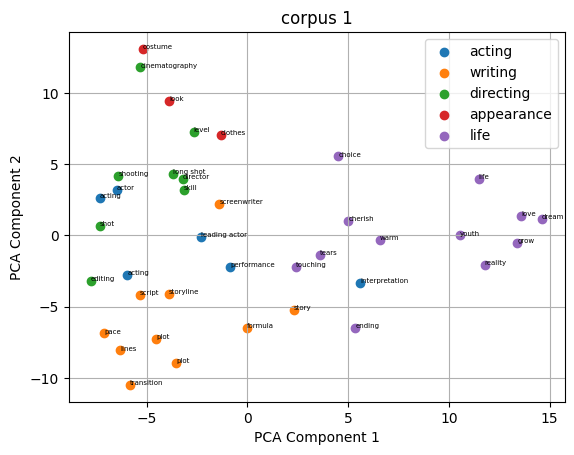

In [195]:

for target, target_words2point in targe2point.items():
        plt.scatter([target_words2point[word][0] for word in target_words2point ],
                        [target_words2point[word][1] for word in target_words2point ]
                        , c= target2color[target], label=target)
           
        for word in target_words2point:
                plt.text(target_words2point[word][0], target_words2point[word][1],targets[target][word], size=5)

plt.title("corpus 1")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.grid(True)
plt.legend()
plt.savefig('tinytimes.jpg',  bbox_inches='tight', dpi=200)

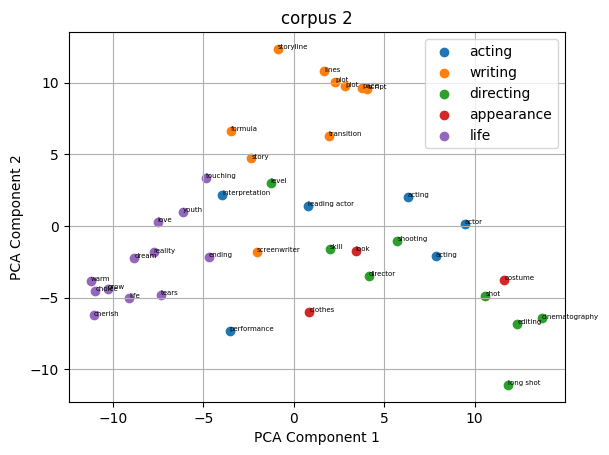

In [196]:
words = list(selected_W2.keys())
vectors = np.array([selected_W2[word] for word in words])

# Apply PCA
pca = PCA(n_components=2)
vectors_reduced = pca.fit_transform(vectors)
word2vec={}
for word, vec in  zip(words, vectors_reduced):
    word2vec[word]=vec
    
    
targe2point={}
for target, target_words2trans in targets.items():
        targe2point[target]={}
        
        for word, translation in target_words2trans.items():
            
            targe2point[target][word]=[word2vec[word][0], word2vec[word][1]]
            
            

for target, target_words2point in targe2point.items():
        plt.scatter([target_words2point[word][0] for word in target_words2point ],
                        [target_words2point[word][1] for word in target_words2point ]
                        , c= target2color[target], label=target)
           
        for word in target_words2point:
                plt.text(target_words2point[word][0], target_words2point[word][1],targets[target][word], size=5)

plt.title("corpus 2")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend()
plt.savefig('lalaland.jpg',  bbox_inches='tight', dpi=200)

In [ ]:
words = list(selected_W2.keys())
vectors = np.array([selected_W2[word] for word in words])

number_of_components = 20
pca = PCA(n_components=number_of_components)
vectors_reduced = pca.fit_transform(vectors)

#let's get the column of vectors_reduced that are most sparse

def compute_sparsity(column_vector):
    # let's compute the sparsity of this column vector
    participate_ratio= np.sum(column_vector**4)
    return participate_ratio

Topn = 5
# let's compute the sparsity of each column
columns_sparsity= [compute_sparsity(vectors_reduced[:,i]) for i in range(number_of_components)]
# let's get the top n most sparse columns
top_n_sparse_columns= np.argsort(columns_sparsity)[-Topn:]
# let's get the Top k words that are higest weighted for each column in the top n most sparse columns
Topk=10
for column_index in top_n_sparse_columns:
    print(f"Top words for column {column_index}:")
    top_w_words = np.argsort(vectors_reduced[:,column_index])[-Topk:]
    for word_index in top_w_words:
        print(words[word_index])
    print("\n")



Top words for column 1:
编剧
台词
节奏
无聊
电影院
毫无
逻辑
文艺
青春
审美


Top words for column 5:
镜头
突兀
剪辑
梦幻
温暖
触动
眼泪
逻辑
审美
荧幕


Top words for column 2:
配乐
镜头
制作
拍摄
梦幻
剪辑
导演
文艺
青春
审美


Top words for column 4:
梦想
珍惜
演技
颜值
突兀
选择
成长
演员
审美
逻辑


Top words for column 0:
节奏
导演
颜值
拍摄
画面
演技
镜头
演员
剪辑
配乐


